In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.vis import *
from model import PoseModel
from transform import *
from dataset import PlanktonDataset
from visualdl import LogWriter, LogReader
from utils.constants import *

%matplotlib inline

In [2]:
img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
csv_filename = 'data/data_{}.csv'

phases = ['train', 'valid', 'test']

# dataset_mean, dataset_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
normalize = Normalize([0.5, 0.5, 0.5], [1, 1, 1])

batch_size = 16

input_size = (384, 384)

_GPU = 4

In [3]:
data_transform = {
    'train': transforms.Compose([
        Rescale(input_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ])
}

datasets = {x: PlanktonDataset(csv_file=csv_filename.format(x),
                               img_dir=img_dir,
                               transform=data_transform[x])
            for x in phases}

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=4)
               for x in phases}

dataset_sizes = {x: len(datasets[x]) for x in phases}

use_gpu = torch.cuda.is_available()

In [4]:
model = PoseModel(model_name=ALEXNET)
# model = nn.DataParallel(model)
model = model.cuda(_GPU)

In [9]:
checkpoints = torch.load('records/2018-02-28_01:49:15//checkpoints/model_best.pth.tar')
model.load_state_dict(checkpoints['state_dict'])

[('Calanoida', 'Hydromedusae', 'Calanoida', 'Amphipoda', 'Polychaeta (class)', 'Calanoida', 'Calanoida', 'Amphipoda', 'Cyclopoida', 'Calanoida', 'Calanoida', 'Hydromedusae', 'Calanoida', 'Amphipoda', 'Calanoida', 'Calanoida'), ('Calanidae', 'Hydromedusae (Order)', 'Acartiidae', 'Gammaridae', 'Polychaeta (class) (Order)', 'Acartiidae', 'Centropagidae', 'Gammaridae', 'Poecilostomatoida', 'Centropagidae', 'Centropagidae', 'Hydromedusae (Order)', 'Centropagidae', 'Gammaridae', 'Centropagidae', 'Centropagidae'), ('Calanus', 'Hydromedusae (Order)', 'Acartiidae (Family)', 'Gammaridae (Family)', 'Polychaeta (class) (Order)', 'Acartiidae (Family)', 'Centropagidae (Family)', 'Gammaridae (Family)', 'Poecilostomatoida (Family)', 'Centropagidae (Family)', 'Centropagidae (Family)', 'Hydromedusae (Order)', 'Centropagidae (Family)', 'Gammaridae (Family)', 'Centropagidae (Family)', 'Centropagidae (Family)'), ('20170516_004', '20170216_003', '20170217_002', '20170307_003', '20170303_002', '20170217_002'

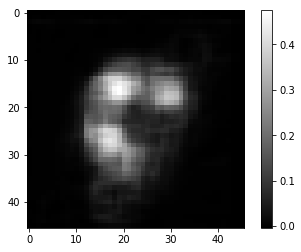

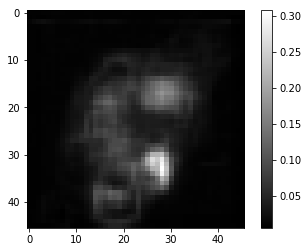

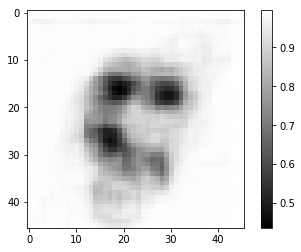

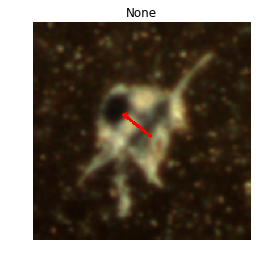

In [12]:
for data in dataloaders['test']:
    model.eval()
    inputs, target, coordinates, classes = data['image'], data['target_map'], data['coordinates'], data['cls']
    print(classes)
    
    if use_gpu:
        inputs = Variable(inputs.cuda(_GPU))
        target = Variable(target.cuda(_GPU))
    else:
        inputs, target = Variable(inputs), Variable(target)
    
    outputs = model(inputs)
    pred_maps = outputs.cpu().data[0].numpy()
    for pred_map in pred_maps:
        plt.figure()
        plt.imshow(pred_map, cmap='gray')
        plt.colorbar()
    
    data0 = normalize.recover(data)
    images = data0['image']
    
    plt.figure()
    show_arrow(images[0], coordinates[0], None)

    break

In [10]:
model

PoseModel (
  (pretrained): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(2, 2), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
  )
  (cpm): Sequential (
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU (inplace)
    (8): Conv